In [ ]:
!pip install -Uqq yfinance hmmlearn pgmpy

In [ ]:
import os
import datetime
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from hmmlearn import hmm
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator, HillClimbSearch

Upload the cleaned data from GWP1

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.xls to data.xls


In [ ]:
data = pd.read_csv('data.xls', index_col=0, parse_dates=True)
data.head()

,five_yr_inflation,treasury_10y,fed_funds_rate,cpi,pce,ind_production,oil_production,refinery_capacity,product_supplied,WTI_Spot,Brent_Spot,Oil_ETF,Energy_Index,SP500,USD_Index
DATE,,,,,,,,,,,,,,,
2020-05-01,0.68,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,26.440001,19.780001,98.800003,18.860001,319.470001,2830.709961
2020-05-04,0.69,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,27.200001,20.389999,99.480003,19.670000,320.750000,2842.739990
2020-05-05,0.71,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,30.969999,24.559999,99.709999,21.510000,321.709991,2868.439941
2020-05-06,0.71,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,29.719999,23.990000,100.089996,20.850000,315.850006,2848.419922
2020-05-07,0.70,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,29.459999,23.549999,99.889999,20.469999,322.589996,2881.189941


In [ ]:
# prepare target forecast variable
data['forecast'] = data['WTI_Spot'].shift(-1)
data.head()

,five_yr_inflation,treasury_10y,fed_funds_rate,cpi,pce,ind_production,oil_production,refinery_capacity,product_supplied,WTI_Spot,Brent_Spot,Oil_ETF,Energy_Index,SP500,USD_Index,forecast
DATE,,,,,,,,,,,,,,,,
2020-05-01,0.68,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,26.440001,19.780001,98.800003,18.860001,319.470001,2830.709961,27.200001
2020-05-04,0.69,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,27.200001,20.389999,99.480003,19.670000,320.750000,2842.739990,30.969999
2020-05-05,0.71,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,30.969999,24.559999,99.709999,21.510000,321.709991,2868.439941,29.719999
2020-05-06,0.71,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,29.719999,23.990000,100.089996,20.850000,315.850006,2848.419922,29.459999
2020-05-07,0.70,0.67,0.05,255.802,13251.7,86.0108,357336.0,18974.0,15354.0,29.459999,23.549999,99.889999,20.469999,322.589996,2881.189941,30.969999


## Step 2

Let us take the example of the oil ETF time series that we collected back in GWP1 to illustrate bull, bear and stagnant regimes.

In [ ]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2025, 1, 1)

In [ ]:
#redownloading the Oil ETF time series
oil_etf = yf.download('USO', start=start, end=end)['Close']

/tmp/ipython-input-18-162597237.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil_etf = yf.download('USO', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed


let us now plot this time series

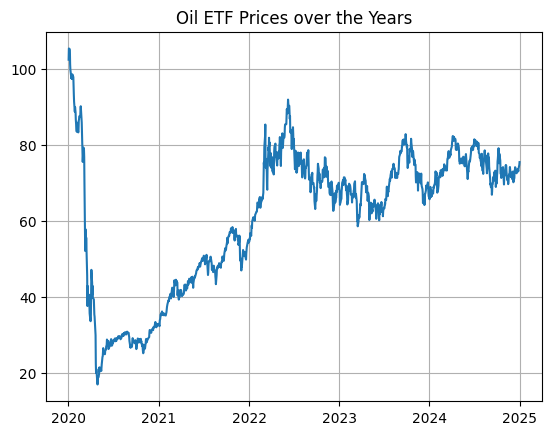

In [ ]:
plt.plot(oil_etf)
plt.title("Oil ETF Prices over the Years")
plt.grid()

Now, let us zoom in some time periods of this time series to illustrate different regimes.

First, the bull regime is shown. The bull regimes is characterised by a continuous upward trend in prices and positive returns.

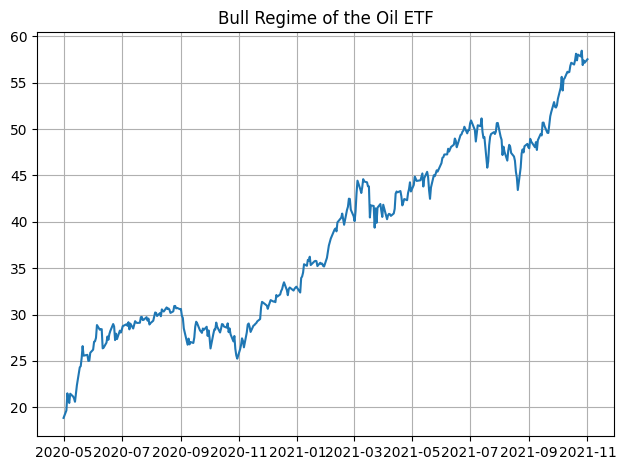

In [ ]:
plt.plot(oil_etf['2020-05-01':'2021-11-01']) #1st May 2020 to 1st November 2021
plt.title("Bull Regime of the Oil ETF")
plt.grid()
plt.tight_layout()

Now, let us visualize a stagnant regime.

A stagnant regime is characterised by a sideways market and the prices usually moves within a range. There is no clear upward or downward trend in prices that sustains.

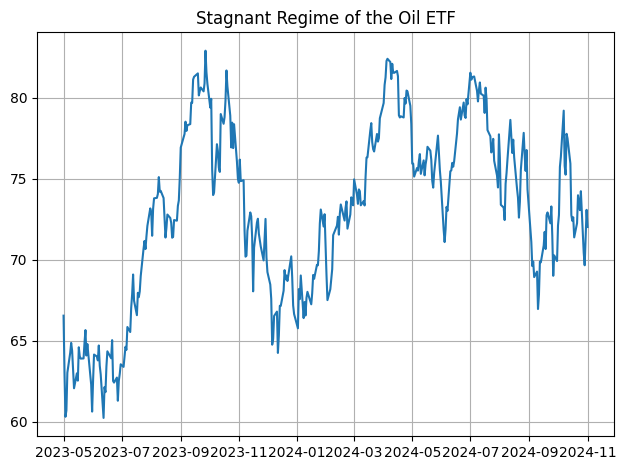

In [ ]:
plt.plot(oil_etf['2023-05-01':'2024-11-01']) #1st May 2023 to 1st November 2024
plt.title("Stagnant Regime of the Oil ETF")
plt.grid()
plt.tight_layout()

Let us now visualize a bear regime.

A bear regime is characterized by a sustained decline in prices and negative returns.

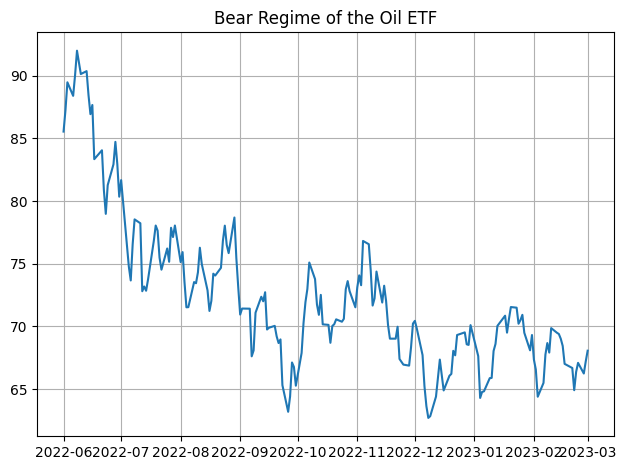

In [ ]:
plt.plot(oil_etf['2022-06-01':'2023-03-01']) #1st June 2022 to 1st March 2023
plt.title("Bear Regime of the Oil ETF")
plt.grid()
plt.tight_layout()
plt.show()

Let us further illustrate these three regimes using examples of stocks from the Indian stock market.

In [ ]:
itc = yf.download('ITC.NS', start=start, end=end)['Close']
vbl = yf.download('VBL.NS', start=datetime.datetime(2025, 1, 1), end=datetime.datetime(2025, 4, 1))['Close']

/tmp/ipython-input-23-3066732524.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  itc = yf.download('ITC.NS', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-23-3066732524.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vbl = yf.download('VBL.NS', start=datetime.datetime(2025, 1, 1), end=datetime.datetime(2025, 4, 1))['Close']
[*********************100%***********************]  1 of 1 completed


First, let us see the time series for ITC

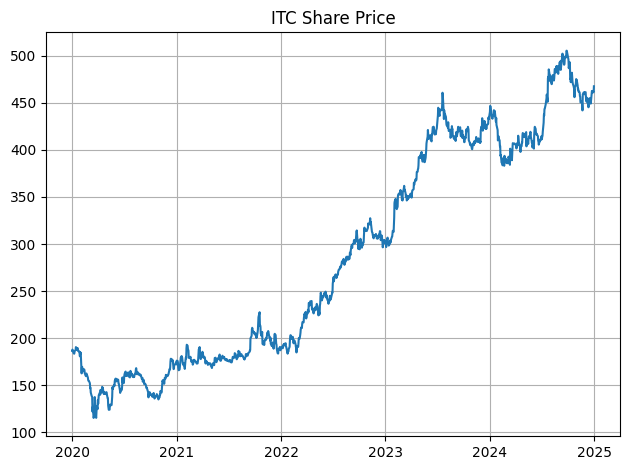

In [ ]:
plt.plot(itc)
plt.title("ITC Share Price")
plt.grid()
plt.tight_layout()
plt.show()

Here, we can zoom in on different time periods to see bull and stagnant regimes

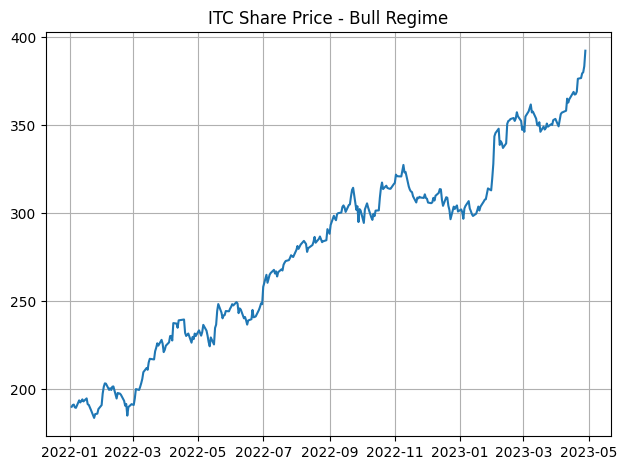

In [ ]:
plt.plot(itc['2022-01-01':'2023-05-01'])
plt.title("ITC Share Price - Bull Regime")
plt.grid()
plt.tight_layout()
plt.show()

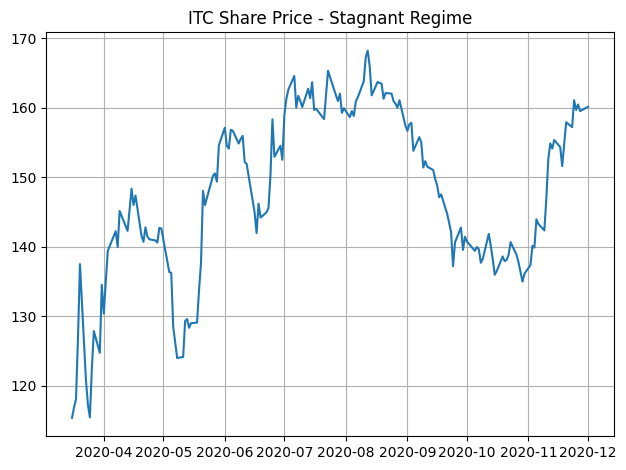

In [ ]:
plt.plot(itc['2020-03-15':'2020-12-01'])
plt.title("ITC Share Price - Stagnant Regime")
plt.grid()
plt.tight_layout()
plt.show()

Let is now examine a bear regime

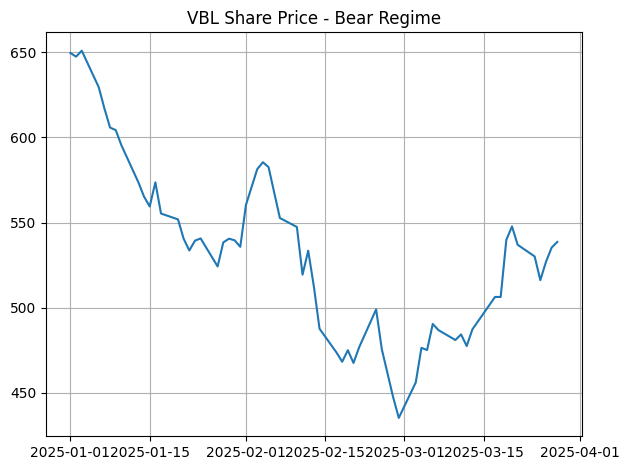

In [ ]:
plt.plot(vbl)
plt.title("VBL Share Price - Bear Regime")
plt.grid()
plt.tight_layout()
plt.show()

# Step 4, 5, 6 and 7

In [ ]:
# do a 80/10/10 train-val-test split
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
train_data, val_data, test_data = data[:train_size].copy(), data[train_size:train_size+val_size].copy(), data[train_size+val_size:].copy()
train_data.shape, val_data.shape, test_data.shape

((949, 16), (118, 16), (120, 16))

## Regime identification using HMM on WTI Spot Price

In [ ]:
def prepare_data(data):
    # input data must be a DataFrame
    # use log return
    data.columns = ['price']
    data['return'] = np.log(data['price'] / data['price'].shift(1))
    data['direction'] = np.where(data['return'] > 0, 1, 0)
    data = data.dropna()
    return data

In [ ]:
train_wti = prepare_data(train_data[['WTI_Spot']].copy())
val_wti = prepare_data(val_data[['WTI_Spot']].copy())
test_wti = prepare_data(test_data[['WTI_Spot']].copy())
train_wti.head()

,price,return,direction
DATE,,,
2020-05-04,27.200001,0.028339,1
2020-05-05,30.969999,0.129802,1
2020-05-06,29.719999,-0.041199,0
2020-05-07,29.459999,-0.008787,0
2020-05-08,30.969999,0.049986,1


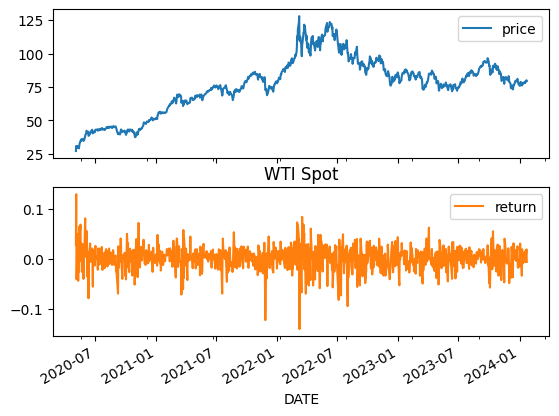

In [ ]:
train_wti[['price', 'return']].plot(subplots=True)
plt.title('WTI Spot')
plt.show()

In [ ]:
def train_hmm(data, n_components=3, n_iter=100, random_state=42, verbose=0, model=None):
  # Reshape the data for the HMM model
  data_np = data['direction'].values.reshape(-1, 1).astype(int)

  if not model:
    model = hmm.CategoricalHMM(n_components=n_components, n_iter=n_iter, random_state=random_state)
    # Fit the model using Baum-Welch
    model.fit(data_np)

  # Run Viterbi algorithm
  logprob, states = model.decode(data_np)

  if verbose:
    # Print all parameters
    print("Start probabilities:", model.startprob_.round(4))
    print("Transition probabilities:", model.transmat_.round(4))
    print("Emission probabilities:", model.emissionprob_.round(4))
    print("\nLog probability of the optimal path:", np.round(logprob,2))
    print("Optimal state sequence (Viterbi):", states)
  return model, states

In [ ]:
train_model, train_states = train_hmm(train_wti, n_components=3, random_state=10, verbose=1)

Start probabilities: [0. 1. 0.]
Transition probabilities: [[0.1928 0.8072 0.    ]
 [0.013  0.3663 0.6207]
 [0.3497 0.1057 0.5446]]
Emission probabilities: [[0.986  0.014 ]
 [0.1745 0.8255]
 [0.4199 0.5801]]

Log probability of the optimal path: -975.6
Optimal state sequence (Viterbi): [1 2 2 0 1 2 2 0 1 2 2 0 1 2 0 1 2 2 2 2 2 2 2 2 0 1 2 0 1 2 2 0 1 2 2 2 0
 1 2 2 0 1 2 2 2 0 1 2 2 0 1 2 2 0 1 2 2 0 1 2 0 1 2 2 2 2 2 0 1 2 0 1 2 0
 1 2 2 2 0 1 2 2 2 0 1 2 0 1 2 0 1 2 2 0 1 2 2 2 0 1 2 2 0 1 2 2 2 0 1 2 0
 1 2 0 1 2 0 1 2 2 0 1 2 0 1 2 2 0 1 2 2 2 0 1 2 2 2 0 1 2 2 0 1 2 2 2 2 2
 0 1 2 2 0 1 2 2 0 1 2 2 2 2 2 0 1 2 2 0 1 2 2 2 0 1 2 2 2 0 1 2 2 0 1 2 2
 0 1 2 2 0 1 2 2 2 2 2 2 2 2 0 1 2 2 2 2 0 1 2 2 0 1 2 0 1 2 2 2 0 1 2 0 1
 2 2 0 1 2 0 1 2 2 2 2 0 1 2 0 1 2 2 0 1 2 2 2 0 1 2 0 1 2 0 1 2 2 0 1 2 2
 0 1 2 2 2 0 1 2 2 2 0 1 2 2 2 2 2 2 2 0 1 2 2 0 1 2 2 2 2 0 1 2 0 1 2 2 0
 1 2 2 2 2 0 1 2 0 1 2 0 1 2 2 2 2 2 2 0 1 2 2 2 2 0 1 2 0 1 2 0 1 2 0 1 2
 0 1 2 2 0 1 2 2 0 1 2 0 1 2 2 2 2 2 2 

In [ ]:
train_wti['State'] = train_states
train_wti.groupby('State').agg({'return': 'mean'})

,return
State,
0,-0.017614
1,0.013531
2,0.004008


State 0 represents bear market (negative returns), State 1 represents bull market (positive returns) and State 2 represents stagnant period (near zero return)

In [ ]:
def plot_hmm_states(data, states=None):
  data = data.copy()
  if states is None:
    if 'State' not in data.columns:
      raise ValueError('State not found. Run HMM before plotting.')
  else:
    data['State'] = states

  # Define colors and labels for each state
  colors = ['red', 'green', 'black']
  state_labels = ['Bear Market', 'Bull Market', 'Stagnant']

  fig, ax = plt.subplots(figsize=(15, 8))
  # Iterate through the states and plot segments with corresponding colors
  for i in range(len(data) - 1):
      ax.plot(data.index[i:i+2], data['price'].iloc[i:i+2], color=colors[data['State'].iloc[i]], linewidth=2)

  # Add legend
  legend_elements = [plt.Line2D([0], [0], color=colors[i], lw=2, label=state_labels[i]) for i in range(len(colors))]
  ax.legend(handles=legend_elements)

  ax.set_title('WTI Spot Price with HMM States')
  ax.set_xlabel('Date')
  ax.set_ylabel('WTI Spot Price')
  plt.grid(True)
  plt.show()

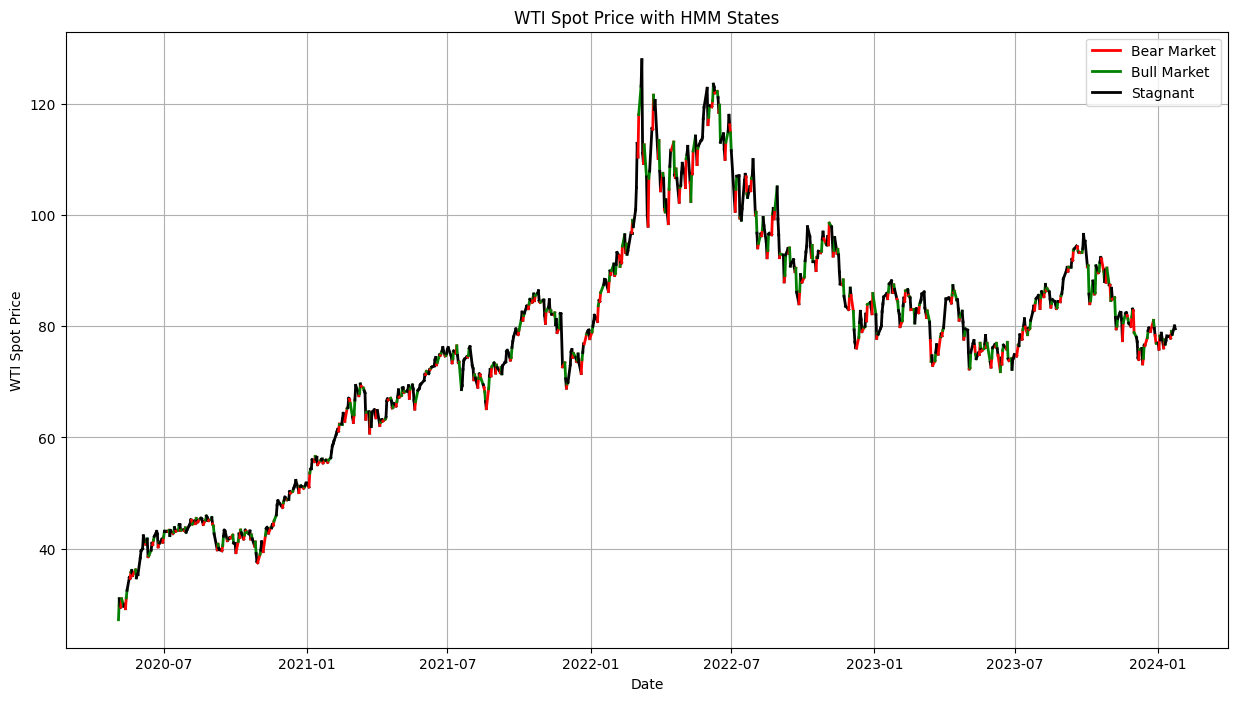

In [ ]:
plot_hmm_states(train_wti)

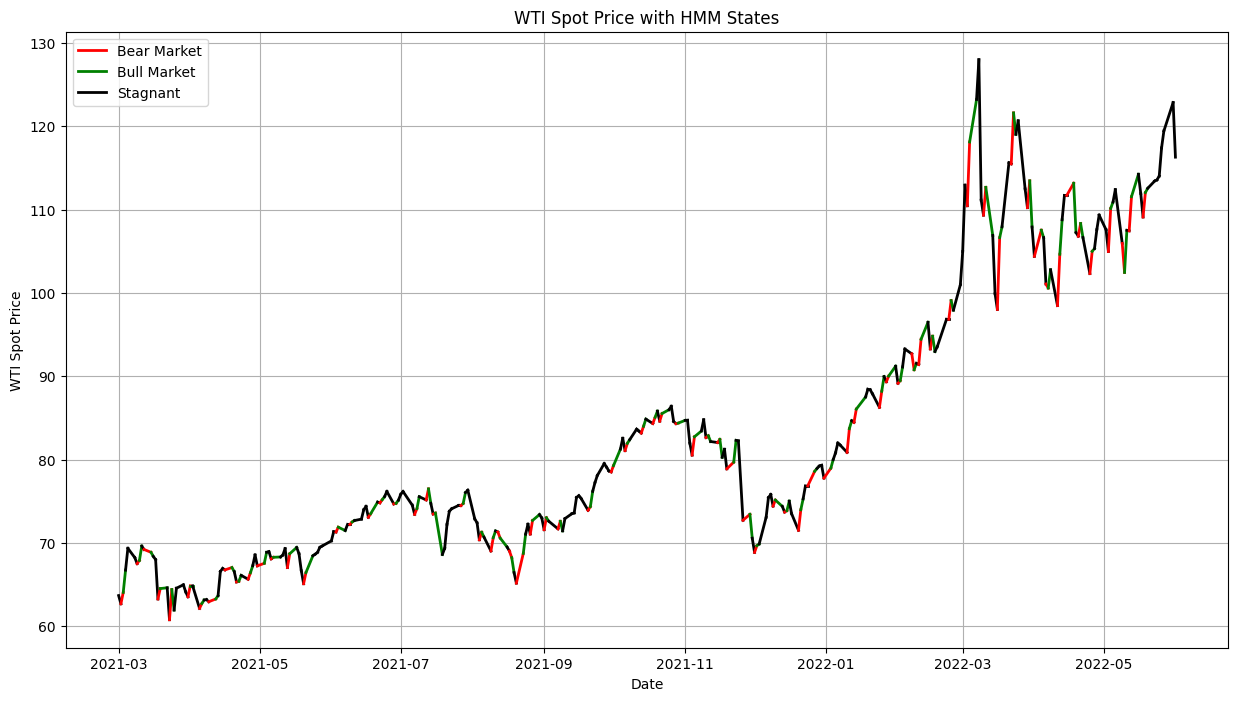

In [ ]:
# a zoomed in plot across covid period
train_wti['State'] = train_states
covid_period = train_wti.loc['2021-03-01':'2022-06-01']
plot_hmm_states(covid_period)

# Step 9

## Discretization of all feature columns

In [ ]:
hmm_models = {}
for column in train_data.columns:
    if 'forecast' in column:
        continue    # Skip the 'forecast' column
    print(f"Training HMM for {column}")
    hmm_models[column] = train_hmm(prepare_data(train_data[[column]].copy()), random_state=10)

Training HMM for five_yr_inflation
Training HMM for treasury_10y
Training HMM for fed_funds_rate
Training HMM for cpi
Training HMM for pce
Training HMM for ind_production
Training HMM for oil_production
Training HMM for refinery_capacity
Training HMM for product_supplied
Training HMM for WTI_Spot
Training HMM for Brent_Spot
Training HMM for Oil_ETF
Training HMM for Energy_Index
Training HMM for SP500
Training HMM for USD_Index


In [ ]:
# discretize the forecast column using WTI_Spot
hmm_models['forecast'] = train_hmm(prepare_data(train_data[['forecast']].copy()), random_state=10, model=hmm_models['WTI_Spot'][0])

In [ ]:
discretized_data = pd.DataFrame({k: v[1] for k, v in hmm_models.items()}, index=train_data.index[1:])
discretized_data.head()

,five_yr_inflation,treasury_10y,fed_funds_rate,cpi,pce,ind_production,oil_production,refinery_capacity,product_supplied,WTI_Spot,Brent_Spot,Oil_ETF,Energy_Index,SP500,USD_Index,forecast
DATE,,,,,,,,,,,,,,,,
2020-05-04,1,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1
2020-05-05,2,1,1,1,1,1,1,1,2,2,1,2,1,2,2,2
2020-05-06,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
2020-05-07,2,2,2,2,2,2,2,2,0,0,0,0,0,2,2,1
2020-05-08,2,2,2,2,2,2,2,2,1,1,1,1,1,2,2,2


In [ ]:
fin_data_state = []
for column in train_data.columns:
    if column not in ["WTI_Spot", 'Brent_Spot', 'Oil_ETF', 'Energy_Index','SP500', 'USD_Index']:
        continue
    column_data = prepare_data(train_data[[column]].copy())
    column_data['State'] = hmm_models[column][1]
    fin_data_state.append(column_data.groupby('State').agg({'return': 'mean'}).rename(columns={'return': column}))
fin_data_state = pd.concat(fin_data_state, axis=1)
fin_data_state

,WTI_Spot,Brent_Spot,Oil_ETF,Energy_Index,SP500,USD_Index
State,,,,,,
0,-0.017614,-0.019392,-0.003106,-0.017368,NaN,-0.005709
1,0.013531,0.019377,0.002302,0.017004,0.003999,0.008440
2,0.004008,-0.008927,0.000491,-0.007366,0.000514,0.000198


As shown above, all the financial asset data except for SP500 have the same interpretation of states, ie 0 for bear, 1 for bull and 2 for stagnant. HMM has failed to capture the bear market regime for SP500, probably because of the overall bullish behaviour of SP500 over the time period used, resulting in small negative return and indistinguisable from the stagnant period return

In [ ]:
nonfin_data_state = []
for column in train_data.columns:
    if column in ["WTI_Spot", 'Brent_Spot', 'Oil_ETF', 'Energy_Index','SP500', 'USD_Index', "forecast"]:
        continue
    column_data = prepare_data(train_data[[column]].copy())
    column_data['State'] = hmm_models[column][1]
    nonfin_data_state.append(column_data.groupby('State').agg({'return': 'mean'}).rename(columns={'return': column}))
nonfin_data_state = pd.concat(nonfin_data_state, axis=1)
nonfin_data_state

,five_yr_inflation,treasury_10y,fed_funds_rate,cpi,pce,ind_production,oil_production,refinery_capacity,product_supplied
State,,,,,,,,,
1,0.014599,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.049562
2,0.001253,0.001905,0.004936,0.000202,0.000398,0.000175,0.00009,-0.00004,-0.006470
0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000


## Hill Climb Search Implementation

In [ ]:
# estimate the model structure
hc = HillClimbSearch(data=discretized_data)
best_structure = hc.estimate(scoring_method='k2', max_indegree=10)

print("Estimated Bayesian Network structure:")
print(best_structure.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

Estimated Bayesian Network structure:
[('five_yr_inflation', 'cpi'), ('five_yr_inflation', 'treasury_10y'), ('five_yr_inflation', 'fed_funds_rate'), ('five_yr_inflation', 'oil_production'), ('five_yr_inflation', 'refinery_capacity'), ('five_yr_inflation', 'ind_production'), ('five_yr_inflation', 'USD_Index'), ('five_yr_inflation', 'WTI_Spot'), ('five_yr_inflation', 'Oil_ETF'), ('treasury_10y', 'Brent_Spot'), ('treasury_10y', 'forecast'), ('treasury_10y', 'pce'), ('treasury_10y', 'cpi'), ('treasury_10y', 'Energy_Index'), ('treasury_10y', 'USD_Index'), ('treasury_10y', 'WTI_Spot'), ('treasury_10y', 'Oil_ETF'), ('fed_funds_rate', 'Brent_Spot'), ('fed_funds_rate', 'forecast'), ('fed_funds_rate', 'pce'), ('fed_funds_rate', 'cpi'), ('fed_funds_rate', 'treasury_10y'), ('fed_funds_rate', 'Energy_Index'), ('fed_funds_rate', 'USD_Index'), ('fed_funds_rate', 'WTI_Spot'), ('fed_funds_rate', 'Oil_ETF'), ('cpi', 'Brent_Spot'), ('cpi', 'forecast'), ('cpi', 'pce'), ('cpi', 'Energy_Index'), ('pce', 'Br

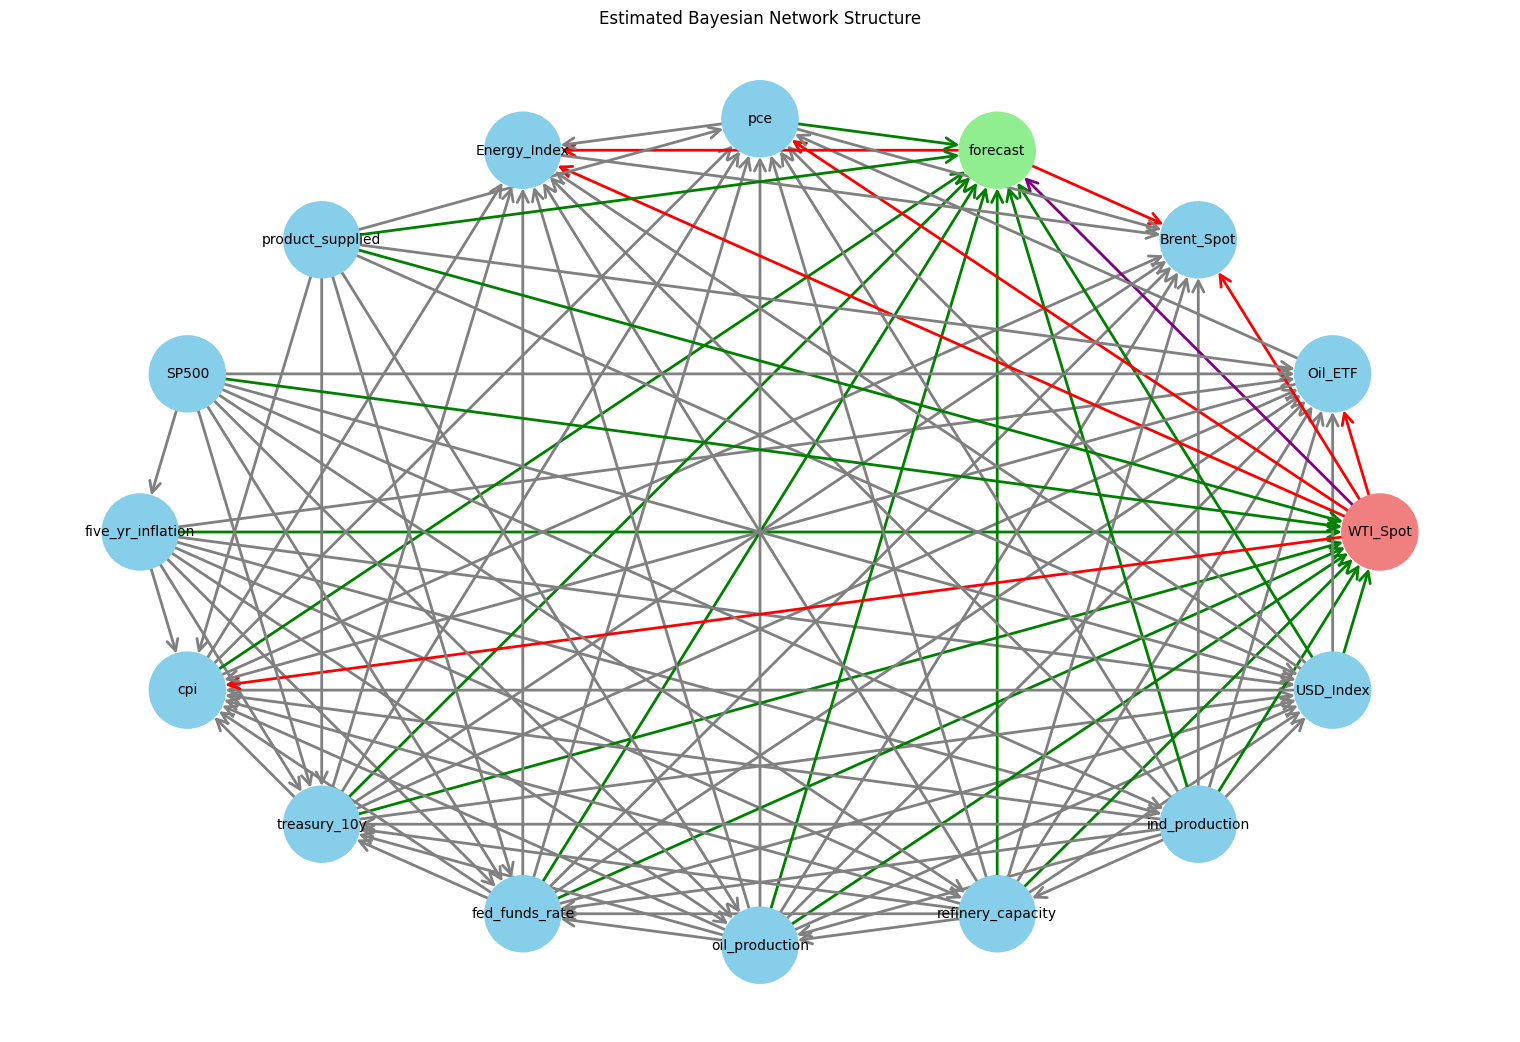

In [ ]:
graph = nx.DiGraph(best_structure.edges())

# Highlight WTI_Spot and forecast
node_colors_map = {node: 'skyblue' for node in graph.nodes()}
node_colors_map['WTI_Spot'] = 'lightcoral'
node_colors_map['forecast'] = 'lightgreen'
node_colors = [node_colors_map[node] for node in graph.nodes()]

# Highlight input and output edges to WTI and forecast node
edge_colors = []
for u, v in graph.edges():
    color_u = node_colors_map[u]
    color_v = node_colors_map[v]
    if color_u != color_v:
        # Highlight edges connecting nodes of different colors
        if (u == 'WTI_Spot' and v == 'forecast') or (u == 'forecast' and v == 'WTI_Spot'):
             edge_colors.append('purple') # Color for edge between WTI and forecast
        elif u in ['WTI_Spot', 'forecast']:
             edge_colors.append('red') # Color for edges from highlighted nodes
        elif v in ['WTI_Spot', 'forecast']:
             edge_colors.append('green') # Color for edges to highlighted nodes
        else:
             edge_colors.append('gray') # For other nodes
    else:
        edge_colors.append('gray') # For other nodes


# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.shell_layout(graph) # Use shell_layout as it is deterministic
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, arrowstyle='->', arrowsize=20, edge_color=edge_colors, width=2)
plt.title("Estimated Bayesian Network Structure")
plt.show()

In [ ]:
model = DiscreteBayesianNetwork(best_structure.edges())
model.fit(discretized_data, estimator=BayesianEstimator, prior_type='K2',
          state_names={col: [0, 1, 2] for col in discretized_data.columns})

In [ ]:
predictions = model.predict(discretized_data.drop(columns=['forecast']))
predictions

  0%|          | 0/194 [00:00<?, ?it/s]

,five_yr_inflation,treasury_10y,fed_funds_rate,cpi,pce,ind_production,oil_production,refinery_capacity,product_supplied,WTI_Spot,Brent_Spot,Oil_ETF,Energy_Index,SP500,USD_Index,forecast
2020-05-04,1,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1
2020-05-05,2,1,1,1,1,1,1,1,2,2,1,2,1,2,2,2
2020-05-06,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
2020-05-07,2,2,2,2,2,2,2,2,0,0,0,0,0,2,2,1
2020-05-08,2,2,2,2,2,2,2,2,1,1,1,1,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,2,2,2,2,2,2,2,2,2,0,1,2,1,2,2,1
2024-01-18,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
2024-01-19,2,2,2,2,2,2,2,2,2,2,0,0,0,2,2,2
2024-01-22,2,2,2,2,2,2,2,2,2,2,1,1,1,2,2,2


<Figure size 800x600 with 0 Axes>

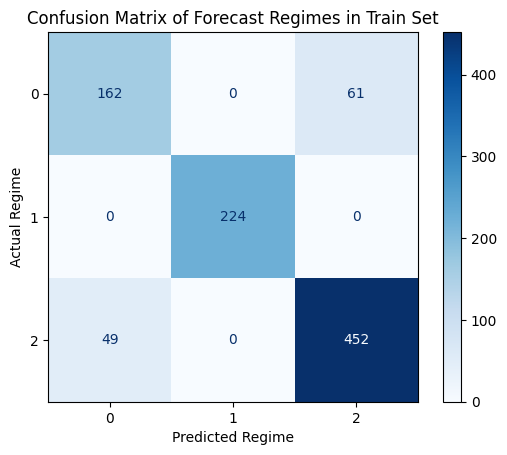

In [ ]:
# a sanity check on predictions using train set data
cm = confusion_matrix(discretized_data['forecast'], predictions['forecast'])
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Forecast Regimes in Train Set')
plt.xlabel('Predicted Regime')
plt.ylabel('Actual Regime')
plt.grid(False)
plt.show()